# Generative Adversarial Networks

Source: [Dive into Deep Learning](https://d2l.ai/chapter_generative-adversarial-networks/gan.html)

In [ ]:
# pip install d2l==1.0.3

## Code with TensorFlow

In [13]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [14]:
# Generate some data drawn from Gaussian
X = tf.random.normal((1000, 2), 0.0, 1)
A = tf.constant([[1, 2], [-0.1, 0.5]])
b = tf.constant([1, 2], tf.float32)
data = tf.matmul(X, A) + b

The covariance matrix is
[[1.01 1.95]
 [1.95 4.25]]


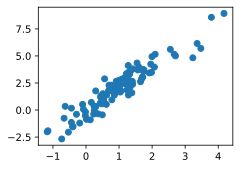

In [15]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, 0].numpy(), data[:100, 1].numpy());
print(f'The covariance matrix is\n{tf.matmul(A, A, transpose_a=True)}')

In [16]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

## Generator

This generator network will be the simplest network possible - a single layer linear model. This is since we will be driving that linear network with a Gaussian data generator. Hence, it literally only needs to learn the parameters to fake things perfectly.

In [18]:
net_G = tf.keras.layers.Dense(2)

### Discriminator

This will use a Multi-layer Perceptron with 3 layers.

In [19]:
net_D = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, activation="tanh", input_shape=(2,)),
    tf.keras.layers.Dense(3, activation="tanh"),
    tf.keras.layers.Dense(1)
])

### Training

In [21]:
def update_D(X, Z, net_D, net_G, loss, optimizer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = tf.ones((batch_size,)) # Labels corresponding to real data
    zeros = tf.zeros((batch_size,)) # Labels corresponding to fake data
    # Do not need to compute gradient for `net_G`, so it is outside GradientTape
    fake_X = net_G(Z)
    with tf.GradientTape() as tape:
        real_Y = net_D(X)
        fake_Y = net_D(fake_X)
        # We multiply the loss by batch_size to match PyTorch's BCEWithLogitsLoss
        loss_D = (loss(ones, tf.squeeze(real_Y)) + loss(
            zeros, tf.squeeze(fake_Y))) * batch_size / 2
    grads_D = tape.gradient(loss_D, net_D.trainable_variables)
    optimizer_D.apply_gradients(zip(grads_D, net_D.trainable_variables))
    return loss_D

In [22]:
def update_G(Z, net_D, net_G, loss, optimizer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = tf.ones((batch_size,))
    with tf.GradientTape() as tape:
        # We could reuse `fake_X` from `update_D` to save computation
        fake_X = net_G(Z)
        # Recomputing `fake_Y` is needed since `net_D` is changed
        fake_Y = net_D(fake_X)
        # We multiply the loss by batch_size to match PyTorch's BCEWithLogits loss
        loss_G = loss(ones, tf.squeeze(fake_Y)) * batch_size
    grads_G = tape.gradient(loss_G, net_G.trainable_variables)
    optimizer_G.apply_gradients(zip(grads_G, net_G.trainable_variables))
    return loss_G

Both the discriminator and the generator performs a binary logistic regression with the cross-entropy loss. We use Adam to smooth the training process. In each iteration, we first update the discriminator and then the generator. We visualize both losses and generated examples.

In [23]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)
    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr_D)
    optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr_G)
    animator = d2l.Animator(
        xlabel="epoch", ylabel="loss", xlim=[1, num_epochs], nrows=2,
        figsize=(5, 5), legend=["discriminator", "generator"])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(
                mean=0, stddev=1, shape=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)
        # Visualize generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(100, latent_dim))
        fake_X = net_G(Z)
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(["real", "generated"])

        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))

    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

loss_D 0.694, loss_G 0.714, 173.2 examples/sec


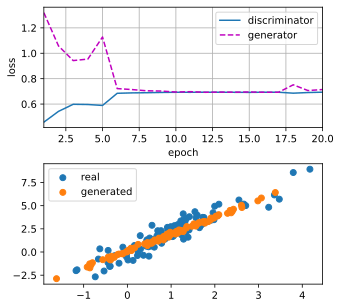

In [24]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter,
      num_epochs,
      lr_D, lr_G,
      latent_dim, data[:100].numpy())